## Supervisor

In [ ]:
from typing import Literal
from langchain_openai import ChatOpenAI
from langgraph.types import Command
from langgraph.graph import StateGraph, MessagesState, START, END
from langchain_core.tools import tool
from langgraph.agents import create_agent
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage, ToolMessage
from pydantic import BaseModel

# Initialize models - supervisor uses more powerful model for decision making
supervisor_model = ChatOpenAI(model='gpt-4.1')
model = ChatOpenAI(model='gpt-4.1-mini')

# System prompt that tells the supervisor how to route tasks
supervisor_system_prompt = """
You are a supervisor managing a team of agents. Based on the user's request, decide which agent should handle the task next.

Available agents:
- weather_agent: Can get weather information for cities
- python_agent: Can execute Python code
- END: Use this when the task is complete
"""

# Tool for executing Python code
@tool
def execute_python_code(code: str) -> str:
   """Execute generated python code. Use print() to output the result: e.g. print(1+1)"""
   return exec(code)

# Tool for getting weather information
@tool
def get_weather(city: str) -> str:
   """Get the weather of a city."""
   return f"The weather in {city} is sunny"

# Agent configurations: model, tools, description, system message
agents = {
    'weather_agent': (
        model,
        [get_weather],
        'weather_agent is capable of getting the weather of a city',
        'You are the "weather_agent". You are responsible for getting the weather of a city.'
    ),
    'python_agent': (
        model,
        [execute_python_code],
        'python_agent is capable of executing python code',
        'You are the "python_agent". You are responsible for executing python code.'
    )    
}

# Supervisor node - decides which agent to call next
def supervisor(state: MessagesState) -> Command[Literal["weather_agent", "python_agent", END]]:
    # Define structured output format for supervisor decisions
    class SupervisorResponse(BaseModel):
        next_agent_reasoning: str
        next_agent: Literal["weather_agent", "python_agent", "END"]
    
    # Use structured output to get consistent supervisor decisions
    structured_supervisor = supervisor_model.with_structured_output(SupervisorResponse)
    
    # Get supervisor's decision on next agent
    response = structured_supervisor.invoke([SystemMessage(content=supervisor_system_prompt)] + state["messages"])
    return Command(goto=response.next_agent, update={"messages": AIMessage(content=response.next_agent_reasoning)})

# Weather agent node - handles weather-related tasks
def weather_agent(state: MessagesState) -> Command[Literal["supervisor"]]:
    agent = create_agent(agents['weather_agent'][0], agents['weather_agent'][1], system_prompt=agents['weather_agent'][3])
    response = agent.invoke(state)
    return Command(
        goto="supervisor",
        update={"messages": response['messages']},
    )

# Python agent node - handles code execution tasks
def python_agent(state: MessagesState) -> Command[Literal["supervisor"]]:
    agent = create_react_agent(agents['python_agent'][0], agents['python_agent'][1], state_modifier=agents['python_agent'][3])
    response = agent.invoke(state)
    return Command(
        goto="supervisor",
        update={"messages": response['messages']},
    )

# Build the state graph
builder = StateGraph(MessagesState)
builder.add_node(supervisor)
builder.add_node(weather_agent)
builder.add_node(python_agent)

# Start with supervisor to route the initial request
builder.add_edge(START, "supervisor")

# Compile the graph into an executable workflow
supervisor = builder.compile()

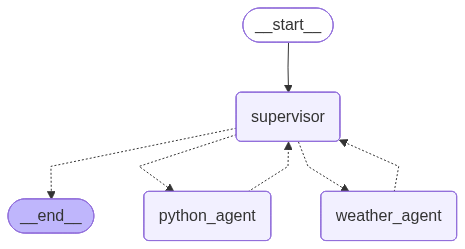

In [2]:
from IPython.display import Image, display
try:
    png_data = supervisor.get_graph().draw_mermaid_png()
    display(Image(png_data))
except Exception as e:
    print(supervisor.get_graph().draw_ascii())


In [ ]:
def print_event(event):
    """Pretty print network events with emojis and better formatting"""
    # Loop through each agent's data in the event
    for agent_name, data in event.items():
        print(f"\n🤖 Agent: {agent_name}")
        
        if 'messages' in data:
            messages = data['messages']
            # Handle list of messages
            if isinstance(messages, list):
                for msg in messages:
                    # Process AI responses
                    if isinstance(msg, AIMessage):
                        if msg.content:
                            print(f"💬 Response: {msg.content}")
                        # Check for tool calls made by the agent
                        if hasattr(msg, 'tool_calls') and msg.tool_calls:
                            for tool_call in msg.tool_calls:
                                # Handle different types of tool calls
                                if tool_call['name'] == 'pass_to_agent':
                                    print(f"🔄 Passing to: {tool_call['args']['agent_name']}")
                                elif tool_call['name'] == 'get_weather':
                                    print(f"🌤️ Getting weather for: {tool_call['args']['city']}")
                                elif tool_call['name'] == 'execute_python_code':
                                    print(f"🐍 Executing Python code:")
                                    code = tool_call['args']['code']
                                    # Format code nicely
                                    for line in code.split('\n'):
                                        print(f"    {line}")
                                else:
                                    print(f"🔧 Tool call: {tool_call['name']} with {tool_call['args']}")
                    # Process tool execution results
                    elif isinstance(msg, ToolMessage):
                        if msg.content != 'None':
                            print(f"⚙️ Tool result: {msg.content}")
            # Handle single message
            else:
                if isinstance(messages, AIMessage):
                    if messages.content:
                        print(f"💬 Response: {messages.content}")


# Stream the workflow execution and print each step
for event in supervisor.stream({"messages": [HumanMessage(content="What is the weather in Tokyo? Use python to print it in reverse")]}):
    print_event(event)


🤖 Agent: supervisor
💬 Response: The user asked for the weather in Tokyo, so first I need to get the weather information for Tokyo before processing it with Python.

🤖 Agent: weather_agent
💬 Response: The user asked for the weather in Tokyo, so first I need to get the weather information for Tokyo before processing it with Python.
🌤️ Getting weather for: Tokyo
⚙️ Tool result: The weather in Tokyo is sunny
💬 Response: The weather in Tokyo is sunny.

Now, using Python to print it in reverse:

```python
weather = "The weather in Tokyo is sunny"
print(weather[::-1])
```

The output will be:

ynnus si oykoT ni rehtaew ehT

🤖 Agent: supervisor
💬 Response: I have obtained the weather information for Tokyo. Now, I need to use python_agent to reverse the string and print it, as requested by the user.
ynnus si oykoT ni rehtaew ehT

🤖 Agent: python_agent
💬 Response: The user asked for the weather in Tokyo, so first I need to get the weather information for Tokyo before processing it with Python.


Task supervisor with path ('__pregel_pull', 'supervisor') wrote to unknown channel branch:to:END, ignoring it.



🤖 Agent: supervisor
💬 Response: The task is complete: I have provided the reversed weather string using Python as requested by the user.


## Supervisor (Tool calling)

In [53]:
from typing import Annotated
from langchain_openai import ChatOpenAI
from langgraph.prebuilt import InjectedState, create_react_agent

model = ChatOpenAI()

supervisor_with_tools_prompt = """
You are a supervisor managing a team of agents. Based on the user's request, decide which agent should handle the task next.

Available agents to call as tools with specific instructions:
- weather_agent: Can get weather information for cities
e.g.
- task='Get the weather in London'
- python_agent: Can execute Python code
e.g.
- task='Write python code to get the 112th fibonacci number'
"""

@tool
def tool_weather_agent(task: str) -> str:
    """Ask the weather_agent to get the weather of a city. E.g. task='Get the weather in London'"""
    agent = create_react_agent(agents['weather_agent'][0], agents['weather_agent'][1], state_modifier=agents['weather_agent'][3])
    response = agent.invoke({'messages': [HumanMessage(content=task)]})
    return response['messages'][-1].content

@tool
def tool_python_agent(task: str) -> str:
    """Use the python_agent to execute python code. E.g. task='Write python code to get the 112th fibonacci number'"""
    agent = create_react_agent(agents['python_agent'][0], agents['python_agent'][1], state_modifier=agents['python_agent'][3])
    response = agent.invoke({'messages': [HumanMessage(content=task)]})
    return response['messages'][-1].content

tools = [tool_weather_agent, tool_python_agent]
# the simplest way to build a supervisor w/ tool-calling is to use prebuilt ReAct agent graph
# that consists of a tool-calling LLM node (i.e. supervisor) and a tool-executing node
supervisor_with_tools = create_react_agent(model, tools, state_modifier=supervisor_with_tools_prompt)

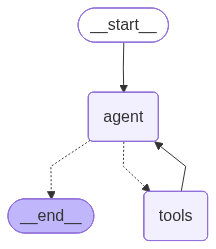

In [54]:
from IPython.display import Image, display

png_data = supervisor_with_tools.get_graph().draw_mermaid_png()
display(Image(png_data))

In [55]:
for event in supervisor_with_tools.stream({"messages": [HumanMessage(content="What is the weather in Tokyo? Use python to print it in reverse")]}):
    print_event(event)


🤖 Agent: agent
🔧 Tool call: tool_weather_agent with {'task': 'Get the weather in Tokyo'}

🤖 Agent: tools
⚙️ Tool result: The weather in Tokyo is sunny.

🤖 Agent: agent
🔧 Tool call: tool_python_agent with {'task': "print('The weather in Tokyo is sunny'[::-1])"}
ynnus si oykoT ni rehtaew ehT

🤖 Agent: tools
⚙️ Tool result: The output of the code print('The weather in Tokyo is sunny'[::-1]) is:
ynnus si okyoT ni rehtaew ehT

🤖 Agent: agent
💬 Response: The weather in Tokyo is sunny. When printed in reverse, it becomes "ynnus si okyoT ni rehtaew ehT".
